# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

In [13]:
%matplotlib inline

import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import tensorflow as tf
import cv2

---
## Load The Data

In [14]:
# Load pickled data
import pickle
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]

training_file =  'datasets/train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']

validation_file =   'datasets/valid.p'
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)   
X_valid, y_valid = valid['features'], valid['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Number of training examples = 34799
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43
Average examples per class = 809


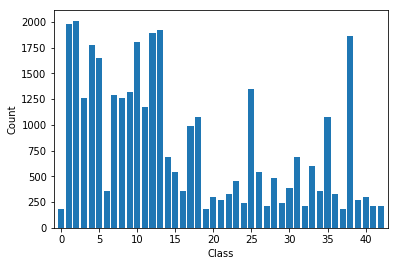

In [15]:
import numpy as np
from pandas.io.parsers import read_csv
signnames = read_csv("signnames.csv").values[:, 1]

n_train = len(y_train)
n_valid = len(y_valid)
image_shape = X_train[0,:,:,:].shape
n_classes = max(y_train+1)
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Average examples per class =", int(np.average(class_counts)))

image_size = image_shape[0]

pyplot.bar( np.arange( 43 ), class_counts, align='center' )
pyplot.xlabel('Class')
pyplot.ylabel('Count')
pyplot.xlim([-1, 43])
pyplot.show()

### Include an exploratory visualization of the dataset

In [ ]:
import matplotlib.pyplot as plt
import random

def show_dataset(X,y):
    print("X shape:",X.shape,"/ y.shape", y.shape)
    print()
    col_width = max(len(name) for name in signnames)
    sign_classes, class_indices, class_counts = np.unique(y, return_index = True, return_counts = True)
    
    #Images
    for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
        print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
        fig = pyplot.figure(figsize = (6, 1))
        fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)
        random_indices = random.sample(range(c_index, c_index + c_count), 10)
        for i in range(10):
            axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
            axis.imshow(X[random_indices[i]], cmap='gray')
        pyplot.show()

    #Graph   
    pyplot.bar(np.arange(43), class_counts, align='center')
    pyplot.xlabel('Class')
    pyplot.ylabel('Count')
    pyplot.xlim([-1, 43])
    plt.savefig('data2.png')

In [ ]:
show_dataset(X_train, y_train)

### Data expansion (flipping, skewing, rotation)
Function definitions as well as examples of each of the four stages.

### Flipping

In [ ]:
def flip_extend(X, y):
    
    flip_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    flip_vertically = np.array([1, 5, 7, 12, 15, 17])
    flip_both = np.array([32, 40])
    cross_flip = np.array([
        [19, 20], [20, 19], 
        [33, 34], [34, 33], 
        [36, 37], [37, 36], 
        [38, 39], [39, 38],])
    
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        
        if c in flip_horizontally:
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        if c in flip_vertically:
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        if c in flip_both:
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        if c in cross_flip[:, 0]:
            flip_class = cross_flip[cross_flip[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
    
    return (X_extended, y_extended)

In [ ]:
import random
def flip_explanation(X,y):
    num_classes = 43
    flip_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    flip_vertically = np.array([1, 5, 7, 12, 15, 17])
    flip_both = np.array([32, 40])
    cross_flip = np.array([
        [19, 20], [20, 19], 
        [33, 34], [34, 33], 
        [36, 37], [37, 36], 
        [38, 39], [39, 38],])
    
    img = np.empty([4, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    
    fig = pyplot.figure(figsize = (1, 1))
    axis = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
    
    for c in range(num_classes):
        img = np.empty([4, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
        
        if c in flip_horizontally:
            print("Class",c,": Horizontal Flip")
            img[0], img[2] = random.choice(X[y == c]), random.choice(X[y==c])
            img[1], img[3] = img[0, :, ::-1, :], img[2, :, ::-1, :]

        if c in flip_vertically:
            print("Class",c,": Vertical Flip")
            img[0], img[2] = random.choice(X[y == c]), random.choice(X[y==c])
            img[1], img[3] = img[0,::-1, :, :], img[2,::-1, :, :]

        if c in flip_both:
            print("Class",c,": Diagonal Flip")
            img[0], img[2] = random.choice(X[y == c]), random.choice(X[y==c])
            img[1], img[3] = img[0,::-1, ::-1, :], img[2,::-1, ::-1, :]

        if c in cross_flip[:, 0]:
            print("Class",c,": Class Changing Flip")
            img[0], img[2] = random.choice(X[y == c]), random.choice(X[y==c])
            img[1], img[3] = img[0,:, ::-1, :], img[2,:, ::-1, :]
            
        if img[0].all() > 0:
            fig = pyplot.figure(figsize = (3, 1));
            fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1);
            for i in range(0,4):
                axis = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
                axis.imshow(img[i])
            pyplot.show()

In [ ]:
flip_explanation(X_train, y_train)

### Rotatating

In [ ]:
from skimage.transform import rotate
from imgaug import augmenters as iaa

def rotate_extend(X , y):
    
    num_classes = 43
    average_set_size = int(len(y_train)/num_classes)
    _, class_counts = np.unique(y, return_counts = True)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    class_images = X_extended
    
    left = iaa.Sequential([
        iaa.Affine(
            rotate=(-10, -2),
            mode="edge"
        )
    ])  
    right = iaa.Sequential([
        iaa.Affine(
            rotate=(2, 10),
            mode="edge"
        )
    ])
    
    for c in range(num_classes):
        class_images = X[y==c]
        
        X_extended = np.append(X_extended, class_images, axis = 0)
        
        if class_counts[c] <= average_set_size:
            counterclockwise_images = left.augment_images(class_images)
            clockwise_images = right.augment_images(class_images)
            X_extended = np.append(X_extended,np.append(counterclockwise_images, clockwise_images, axis = 0) , axis = 0)
            
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
          
    return (X_extended, y_extended)

In [ ]:
from skimage.transform import rotate
def rotation_explaination(X):
    img = [X for i  in range(3)]
    img[1] = rotate(img[1], -15, mode='edge')
    img[2] = rotate(img[2], 15, mode='edge')

    print("    Unrotated         Rotated Right      Rotated Left")
    fig = pyplot.figure(figsize = (3, 1))
    fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)
    for i in range(0,3):
        axis = fig.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
        axis.imshow(img[i])
    pyplot.show()

In [ ]:
rotation_explaination(X_train[3333])

### Scale

In [ ]:
def scale_extend(X, y):
    num_classes = 43
    average_set_size = int(len(y_train)/num_classes)
    _, class_counts = np.unique(y, return_counts = True)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    class_images = X_extended
    
    downscale = iaa.Sequential([
        iaa.Affine(
            scale={"x": (0.8, 1.0), "y": (0.8, 1.0)},
            mode="reflect"
        )
    ])
    upscale = iaa.Sequential([
        iaa.Affine(
            scale={"x": (1.0, 1.2), "y": (1.0, 1.2)},
            mode="reflect"
        )
    ])
    
    for c in range(num_classes):
        class_images = X[y==c]
        
        X_extended = np.append(X_extended, class_images, axis = 0)
        
        if class_counts[c] <= average_set_size:
            downscale_images = downscale.augment_images(class_images)
            upscale_images = upscale.augment_images(class_images)
            X_extended = np.append(X_extended,np.append(downscale_images, upscale_images, axis = 0) , axis = 0)
            
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
 
    return (X_extended, y_extended)

In [ ]:
def scale_explaination(X):
    img = [X for i  in range(3)]
    bothscale = iaa.Sequential([
        iaa.Affine(
            scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},
            mode="edge"
        )
    ])   
    img[1] = bothscale.augment_image(img[0])
    img[2] = bothscale.augment_image(img[0])

    print("    Untouched         Example One        Example Two ")
    fig = pyplot.figure(figsize = (3, 1))
    fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)
    for i in range(0,3):
        axis = fig.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
        axis.imshow(img[i])
    pyplot.show()

In [ ]:
scale_explaination(X_train[3333])

### Affine

In [ ]:
def affine_extend(X, y):  
    num_classes = 43
    average_set_size = int(len(y_train)/num_classes)
    _, class_counts = np.unique(y, return_counts = True)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    class_images = X_extended
    
    fine = iaa.Sequential([
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            shear=(-8, 8),
            mode="edge"
        ),
        iaa.Add((-40,40)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 0.5)))
    ])
    
    for c in range(num_classes):
        class_images = X[y==c]
        
        X_extended = np.append(X_extended, class_images, axis = 0)
        
        if class_counts[c] <= average_set_size:
            X_extended = np.append(X_extended, fine.augment_images(class_images), axis = 0)
            
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
 
    return (X_extended, y_extended)

In [ ]:
def affine_explaination(X):
    
    img = [X for i  in range(3)]
    fine = iaa.Sequential([
        iaa.Affine(
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            shear=(-8, 8),
            mode="edge"
        ),
        iaa.Add((-40,40)),
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 0.5)))
    ])
    img[1] = fine.augment_image(img[0])
    img[2] = fine.augment_image(img[0])
    
    print("    Untouched         Example One        Example Two ")
    fig = pyplot.figure(figsize = (3, 1))
    fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)
    for i in range(0,3):
        axis = fig.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
        axis.imshow(img[i])
    plt.show()

In [ ]:
affine_explaination(X_train[3333])

In [ ]:
X_train.shape

### Pre-process the Data Set (normalization, grayscale, etc.)

Here, we apply the four data expantions

In [ ]:
X_train, y_train = flip_extend(X_train, y_train)
X_train, y_train = rotate_extend(X_train, y_train) # these attempt
X_train, y_train = scale_extend(X_train, y_train)  # to even out the class data
X_train, y_train = affine_extend(X_train, y_train) # by only adding to the lowest half

In [16]:
X_train.shape

(34799, 32, 32, 3)

In [ ]:
show_dataset(X_train, y_train)

In [18]:
import numpy as np
from sklearn.utils import shuffle
from skimage import exposure

def preprocess_dataset(X, y = None):
    #This equation is converting the colors into greyscale
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    #normalized and mean zero
    X = (X - 128)/ 128
    
    X = X.reshape(X.shape + (1,)) 
    
    return X, y

In [19]:
def preprocess_explaination(X):
    fig = pyplot.figure(figsize = (3, 1))
    gray_image = np.array((0.299*X[:, :, 0] + 0.587*X[:, :, 1] + 0.114*X[:, :, 2]))
    
    normalized_image = ((gray_image-128) / 128)
    
    listed_images = [gray_image, normalized_image]
    
    print("       Greyscale                  Normalized")
    
    axis = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    axis.imshow(X)
    axis = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    axis.imshow(gray_image, cmap='gray')
    axis = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    axis.imshow(normalized_image, cmap='gray')

       Greyscale                  Normalized


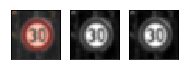

In [20]:
preprocess_explaination(X_train[3333])

In [21]:
X_train, y_train = preprocess_dataset(X_train, y_train)
X_valid, y_valid = preprocess_dataset(X_valid, y_valid)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

In [6]:
import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 75
BATCH_SIZE = 128
PATIENCE = 10

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc0   = flatten(conv2)
    
    # Layer 3
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    # Layer 4
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    # Layer 5
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    best_so_far = 0
    patience_cnt = 0

    print("Training...")
    print()
    for epoch in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid)
        if validation_accuracy>(best_so_far*1.01):
            best_so_far = validation_accuracy
            patience_cnt = 0
            saver.save(sess, './lenet')
            print("Model saved")
        else:
            patience_cnt+=1
        if patience_cnt > PATIENCE:
            print("Early stopping...")
            break
        print("EPOCH {} ...".format(epoch+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

In [11]:
X_train.shape

NameError: name 'X_train' is not defined

In [12]:
testing_file= 'datasets/test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)   
X_test, y_test = test['features'], test['labels']
X_test, y_test = preprocess_dataset(X_test, y_test)

NameError: name 'pickle' is not defined

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [22]:
import glob
import matplotlib.image as mpimg
filelist = glob.glob('internet test/*.jpg')

X_internet = np.array([mpimg.imread(fname) for fname in filelist])

In [23]:
for i in range(len(signnames)):
    print(str(i)+": "+signnames[i])

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing by vehic

In [24]:
y_internet = np.array([1,9,14,2,35,11])
X_internet, y_internet = preprocess_dataset(X_internet, y_internet)
X_internet=X_internet.reshape((6,32,32))

IndexError: too many indices for array

(0,) (6,)


NameError: name 'random' is not defined

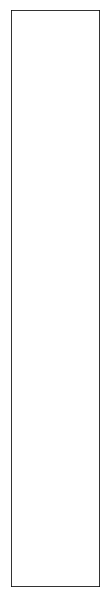

In [25]:
print(X_internet.shape, y_internet.shape)
fig = pyplot.figure(figsize = (4, 4))
fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)
for i in range(0,6):
    axis = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    I = random.choice(X_train[y_train==y_internet[i]]).reshape((32, 32))
    pyplot.imshow(I,cmap = 'gray')

    axis = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    axis.imshow(X_internet[i], cmap='gray')
pyplot.show()


In [ ]:
X_internet=X_internet.reshape((6,32,32,1))

### Predict the Sign Type for Each Image and Show Accuracy

In [ ]:
prediction = tf.argmax( logits, 1 )
with tf.Session() as sess:
    # Load the weights and bias
    saver.restore(sess, './lenet')
    output = sess.run(prediction, feed_dict={
        x: X_internet})
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_internet, y: y_internet})

In [ ]:
print('Predictions:')
print(output)
print('Real:')
print(y_internet)
print('Accuracy:')
print(test_accuracy)
print()
print(signnames[output])
print()
print(signnames[y_internet])
fig = pyplot.figure(figsize = (4, 3))
fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.1, wspace = 0.1)

for i in range(0,6):
   
    axis = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    I = X_internet[i].reshape((32, 32))
    pyplot.imshow(I,cmap = 'gray')

    
    axis = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    I = random.choice(X_train[y_train==output[i]]).reshape((32, 32))
    pyplot.imshow(I,cmap = 'gray')


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [3]:
def test_net(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_internet})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_top_5=test_net(X_internet, sess)


print("Top softmax probabilities:")
plt.figure(figsize=(15, 16))
for i in range(6):
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(X_internet[i].reshape((32,32)), cmap = 'gray') 
    plt.title(str(i+1)+": "+signnames[y_internet[i]])
    plt.axis('off')
    plt.subplot(6, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), signs_top_5.values[i, :])
    labs=[signnames[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.savefig('softmax.png')

NameError: name 'saver' is not defined

In [ ]:
for i in range(6):
    
    plt.bar(signs_top_5.indices[i],signs_top_5.values[i], align='center', alpha=0.5)
    plt.xlim([0,42])
    plt.title("confidence for predictions")

The network has not seen examples that are closely related to the small 50/km sign or the oddly made stop sign. 
There is a failure in the methodology that led to these very confident wrong answers, probably from not having these specially written stop signs and from not having small sign examples of 50/km signs, as well as not having a deep enough repersentation of what it means to be in each class. There are some bad examples of blurry indistinguishable signs in the data set that may have led to confusion in edge cases.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.